## 1. Import Libraries and Load Country Relationships Data


In [15]:
import pandas as pd
from itertools import combinations
from collections import Counter

# Load the previous cleaned file (adjust path if needed)
df = pd.read_csv('/Users/muhammaddildar/Desktop/20th_century_scraping/relationships_dataframe.csv')

# Convert stringified lists to actual Python lists
df['Countries'] = df['Countries'].apply(eval)


## 2. Create Country Pairs and Generate Edge List


In [16]:
# Build all possible undirected country pairs
pair_list = []
for country_list in df['Countries']:
    if len(country_list) > 1:
        for pair in combinations(sorted(set(country_list)), 2):
            pair_list.append(pair)

# Count how often each pair appears
pair_counts = Counter(pair_list)

# Create a DataFrame of the edges
edges_df = pd.DataFrame([(a, b, count) for (a, b), count in pair_counts.items()],
                        columns=['source', 'target', 'value'])

# Save to CSV
edges_df.to_csv('/Users/muhammaddildar/Desktop/20th_century_scraping/country_relationships.csv', index=False)

# Preview
edges_df.head()

source   target  value
0  Austria   France      1
1  Germany   Russia      1
2  Austria  Germany      1
3   France   Poland      2
4   France  Germany      4

## 3. Create Static Network Graph Using NetworkX


In [3]:
import networkx as nx

# Load the new edge list
df = pd.read_csv('/Users/muhammaddildar/Desktop/20th_century_scraping/country_relationships.csv')

# Create a NetworkX graph object
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='value', create_using=nx.Graph())

# Check basic info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 52
Number of edges: 99


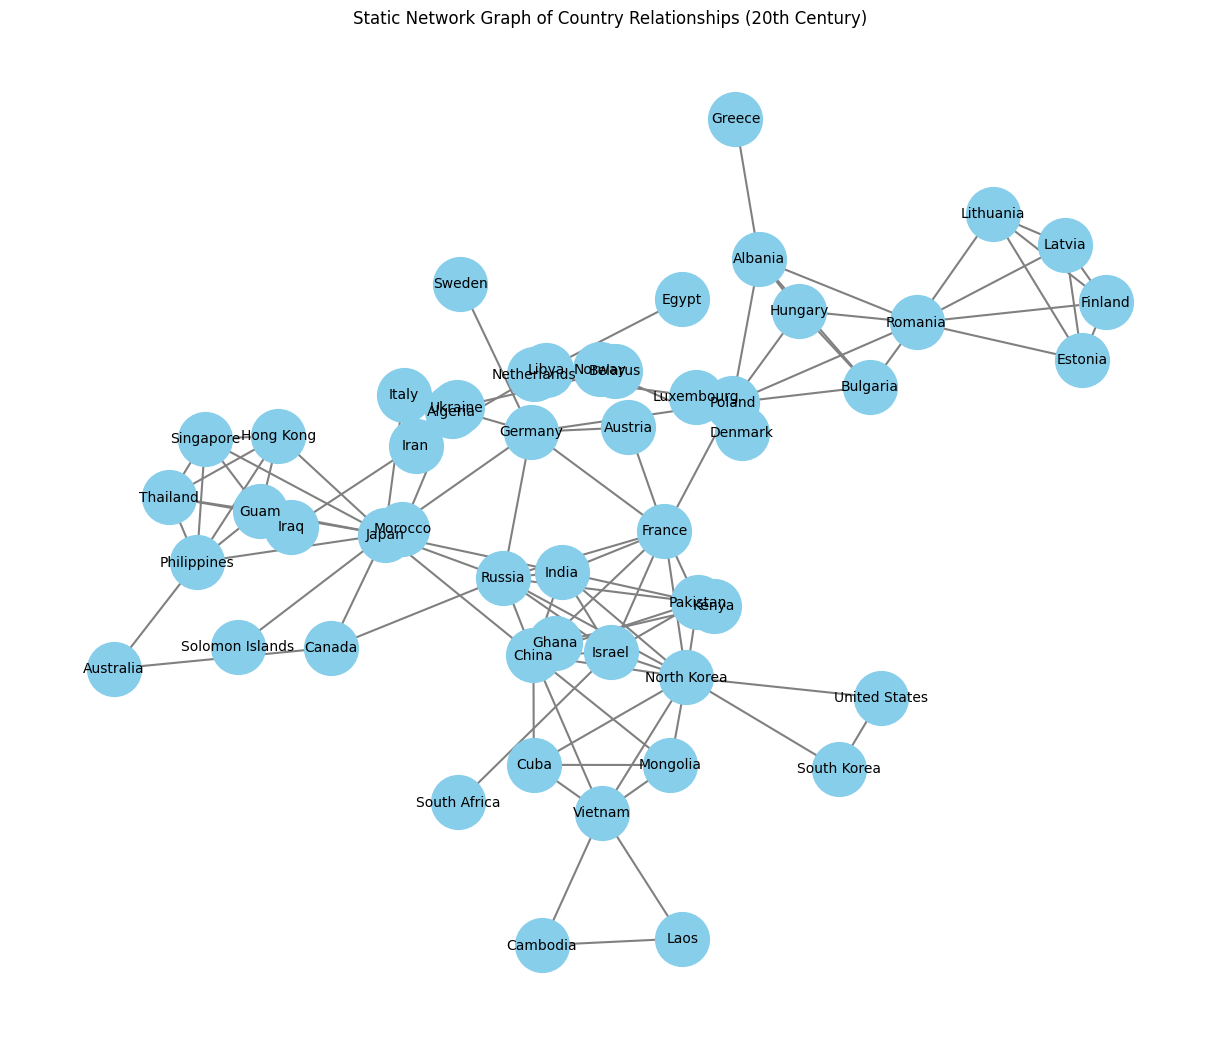

In [4]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 10))

# Define layout (for better spacing of nodes)
pos = nx.kamada_kawai_layout(G)

# Draw the graph
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=1500,
    font_size=10,
    width=1.5
)

plt.title("Static Network Graph of Country Relationships (20th Century)")
plt.show()


In [5]:
from pyvis.network import Network

# Create a Pyvis network object
net = Network(notebook=True, width="1200px", height="800px", bgcolor="#222222", font_color="white")

# Load graph from NetworkX
net.from_nx(G)

# Add controls
net.show_buttons(filter_=['physics'])  # Optional filter menu

# Optional repulsion physics to make layout stable
net.repulsion()

# Save and view
net.show("country_interactive.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## 4. Apply Leiden Algorithm to Detect Communities


In [9]:
from cdlib import algorithms

communities = algorithms.leiden(G)
new_com = communities.to_node_community_map()
dict_com = {k: v[0] for k, v in new_com.items()}
dict_com


{'France': 0,
 'Russia': 0,
 'China': 0,
 'India': 0,
 'Israel': 0,
 'North Korea': 0,
 'Pakistan': 0,
 'South Africa': 0,
 'Cambodia': 0,
 'Laos': 0,
 'Vietnam': 0,
 'Cuba': 0,
 'Mongolia': 0,
 'South Korea': 0,
 'United States': 0,
 'Poland': 1,
 'Estonia': 1,
 'Latvia': 1,
 'Lithuania': 1,
 'Albania': 1,
 'Greece': 1,
 'Finland': 1,
 'Romania': 1,
 'Bulgaria': 1,
 'Hungary': 1,
 'Japan': 2,
 'Guam': 2,
 'Hong Kong': 2,
 'Philippines': 2,
 'Singapore': 2,
 'Thailand': 2,
 'Australia': 2,
 'Solomon Islands': 2,
 'Canada': 2,
 'Egypt': 3,
 'Libya': 3,
 'Iran': 3,
 'Iraq': 3,
 'Austria': 4,
 'Germany': 4,
 'Sweden': 4,
 'Italy': 4,
 'Denmark': 5,
 'Norway': 5,
 'Luxembourg': 6,
 'Netherlands': 6,
 'Belarus': 7,
 'Ukraine': 7,
 'Algeria': 8,
 'Morocco': 8,
 'Ghana': 9,
 'Kenya': 9}

## Community Detection Observations (Leiden Algorithm)

After applying the Leiden algorithm to the 20th-century country relationships network, the countries were grouped into several distinct communities. These communities represent clusters of countries with strong interconnections, based on co-mentions in historical contexts.

### 🧩 Observed Communities & Possible Historical Significance:

- **Community 0** (e.g., France, China, Russia, India, Pakistan, Israel):  
  This group includes countries heavily involved in **major global conflicts** like World Wars and the Cold War. Their tight connections reflect shared geopolitical significance, alliances, and rivalries.

- **Community 1** (e.g., Poland, Hungary, Romania, Bulgaria):  
  This cluster represents **Eastern European** countries, which historically shared political alignment and Soviet influence during the **Cold War era**.

- **Community 2** (e.g., Japan, Hong Kong, Philippines, Thailand):  
  These countries are mostly part of **East and Southeast Asia**, likely grouped due to their historical ties during **WWII** and post-war economic/political partnerships.

- **Community 3** (e.g., Austria, Germany, Italy):  
  These **Central European** nations were prominent players in both World Wars, and their close ties are historically consistent.

- **Community 4** (e.g., Libya, Iran, Egypt, Iraq):  
  These countries share **Middle Eastern/North African** identities and were often mentioned together in the context of **conflicts, revolutions, and colonial transitions**.

- **Community 5, 6, 7** (e.g., isolated pairs like Norway–Denmark or Netherlands–Luxembourg):  
  These may reflect **region-specific historical alliances** or simply fewer mentions in the dataset.

### 🧠 Conclusion:

The community partitions generally **make sense historically**, aligning with known geopolitical blocks, regional conflicts, and alliances. It is interesting to see how **network science confirms historical narratives**, highlighting dense interaction between countries with shared political, economic, or cultural ties.


## 5. Visualize Communities in an Interactive Network (Pyvis)


In [10]:
from pyvis.network import Network

# Add the community info to each node
nx.set_node_attributes(G, dict_com, 'group')

# Create a new Pyvis network object
com_net = Network(notebook=True, width="1200px", height="800px", bgcolor="#222222", font_color="white")

# Add graph with community groups
com_net.from_nx(G)

# Optional: enable layout buttons and stabilize physics
com_net.show_buttons(filter_=['physics'])
com_net.repulsion()

# Save with a new name
com_net.show("country_communities.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## 6. Calculate Degree, Closeness, and Betweenness Centrality


In [13]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Convert to DataFrame for comparison
centrality_df = pd.DataFrame({
    'Degree': degree_centrality,
    'Closeness': closeness_centrality,
    'Betweenness': betweenness_centrality
})

# Sort by Degree Centrality
centrality_df_sorted = centrality_df.sort_values(by='Degree', ascending=False)
centrality_df_sorted.head(10)


Degree  Closeness  Betweenness
Japan        0.235294   0.331397     0.172497
North Korea  0.215686   0.312130     0.093660
China        0.196078   0.335539     0.088261
Russia       0.176471   0.331397     0.051359
France       0.176471   0.339787     0.135255
Romania      0.156863   0.241830     0.103529
Germany      0.137255   0.323411     0.122144
India        0.137255   0.315802     0.013294
Israel       0.137255   0.291773     0.028235
Pakistan     0.117647   0.288636     0.000000

## Centrality Measures Observations

We calculated and visualized the top 10 countries in the network based on three centrality metrics: **degree**, **closeness**, and **betweenness**. These metrics help us understand the importance of each country within the network of 20th-century relationships.

### 🌐 Degree Centrality:
- **Top Countries:** Japan, North Korea, China, Russia, France
- **Observation:** These countries have the **most direct connections** to others in the network. This reflects their **high level of involvement** in various historical events, alliances, or conflicts throughout the 20th century.

### 🔄 Closeness Centrality:
- **Top Countries:** France, China, Russia, Japan, Germany
- **Observation:** These countries are **well-positioned** in the network to reach others quickly. Their central locations imply that they played **influential or mediating roles** in global affairs.

### 🔗 Betweenness Centrality:
- **Top Countries:** Japan, France, Germany, Romania, North Korea
- **Observation:** These countries often lie on the **shortest paths between other countries**, suggesting they served as **bridges or key intermediaries** in international relations. 
- Pakistan appears in the top 10 by degree and closeness but not in betweenness, indicating it is **well connected** but **not a central bridge** in indirect connections.

### 🧠 Conclusion:
The centrality metrics highlight countries that were not only powerful but also **strategically important** in global networks of influence. The presence of both major powers and regionally significant nations (like Pakistan and Romania) shows the **diverse roles** countries played in shaping 20th-century history.


## 7. Visualize Top 10 Countries by Centrality Measures


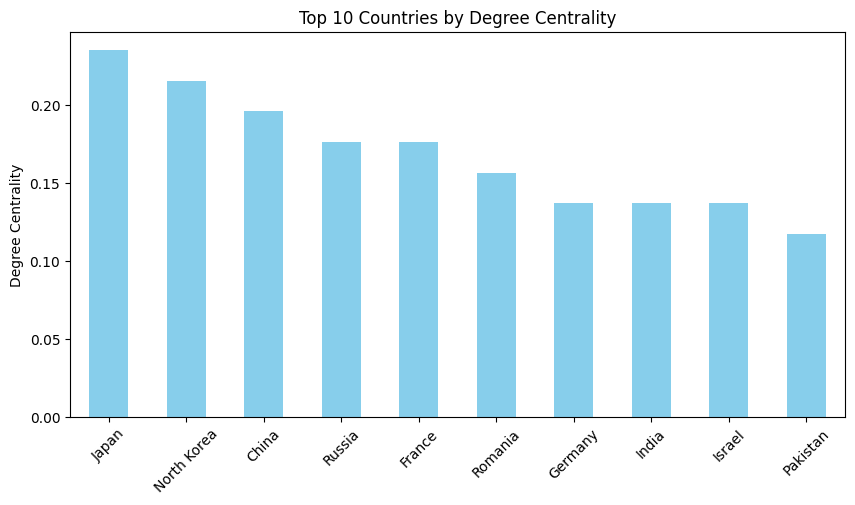

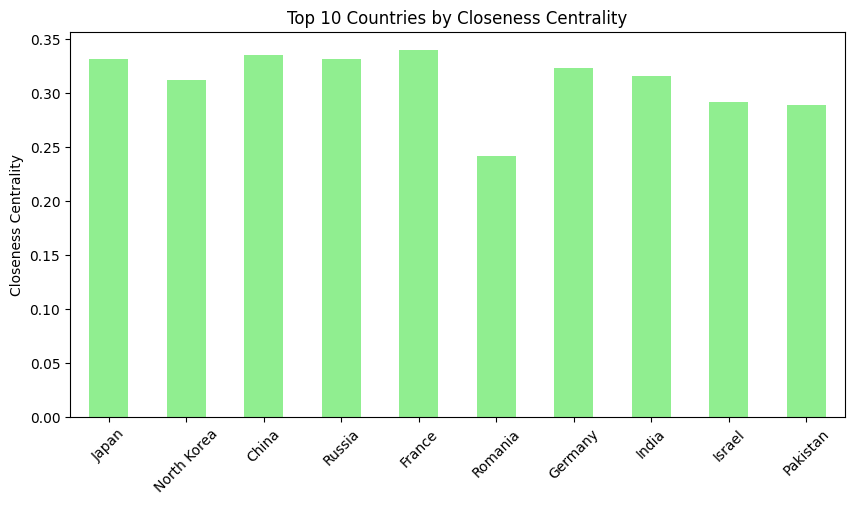

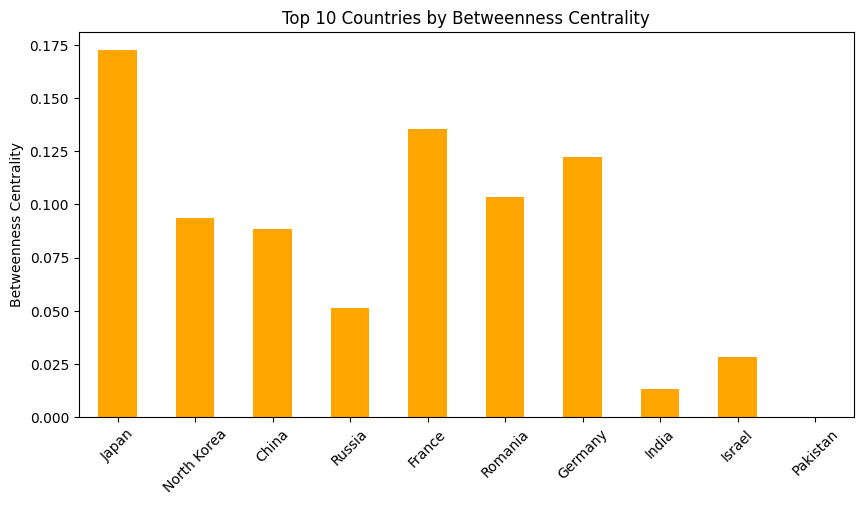

In [12]:
import matplotlib.pyplot as plt

# Degree Centrality Chart
plt.figure(figsize=(10, 5))
centrality_df_sorted['Degree'].head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Countries by Degree Centrality")
plt.ylabel("Degree Centrality")
plt.xticks(rotation=45)
plt.show()

# Closeness Centrality Chart
plt.figure(figsize=(10, 5))
centrality_df_sorted['Closeness'].head(10).plot(kind='bar', color='lightgreen')
plt.title("Top 10 Countries by Closeness Centrality")
plt.ylabel("Closeness Centrality")
plt.xticks(rotation=45)
plt.show()

# Betweenness Centrality Chart
plt.figure(figsize=(10, 5))
centrality_df_sorted['Betweenness'].head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Countries by Betweenness Centrality")
plt.ylabel("Betweenness Centrality")
plt.xticks(rotation=45)
plt.show()
